In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Conformal\ Prediction


/content/drive/MyDrive/Conformal Prediction


In [3]:
! ls

'Conformal Pred.ipynb'		   lightning_logs	   'Tail Risks.ipynb'
'EnbPI for TS forecasting.ipynb'   plot_ts-tutorial.ipynb


In [4]:
! pip install mapie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.6/178.6 kB 3.5 MB/s eta 0:00:00


In [39]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pylab as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, uniform, ks_2samp, mannwhitneyu, chi2_contingency
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from mapie.metrics import (coverage_width_based, regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap

warnings.simplefilter("ignore")

# Exploring Adatpive and Weighted Conformal Prediction Methods in the Presence of Covariate Shift

In predictive modeling, particularly for time series and real-world data, it's crucial to not only make accurate predictions but also to quantify the uncertainty around those predictions. This is where conformal prediction becomes essential. Conformal prediction has gained popularity because it provides prediction intervals with guaranteed coverage, without assuming a specific distribution of the data. Its flexibility and robustness have made it widely adopted in various fields, from medical diagnoses to financial forecasting. The method’s distribution-free nature means that it can deliver confidence intervals that contain the true outcome with a specified probability, which is invaluable in high-stakes scenarios.

There is currently a lot of research going on in this field. For this publication, we will like to explore **Weighted Conformal Prediction (WCP)** method of  **Ryan J. Tibshirani et al** paper **Conformal Prediction Under Covariate Shift**, and compare it to the **Adaptive Conformal Inference (ACI)** method.

The ACI method dynamically adjusts its prediction intervals in response to the data’s evolving characteristics, making it particularly useful for time-series data. WCP, on the other hand, focuses on handling covariate shift, where the training and test data distributions differ—a common occurrence in real-world applications like financial markets. WCP accounts for this shift by weighting the nonconformity scores based on the difference between the training and test distributions. This paper explores both methods to determine which is better suited for scenarios where covariate shift is prevalent.

Covariate shift is a situation where the distribution of input variables changes between the training and testing phases, but the relationship between inputs and outputs remains constant. In fields like finance, covariate shift is frequent as market conditions, economic factors, and external events constantly evolve. Handling this shift effectively is critical to maintaining the reliability of a predictive model. The Weighted Conformal Prediction model is designed to handle this challenge by using likelihood ratios to adjust for these shifts. Meanwhile, ACI provides a more flexible, adaptive approach that can still be useful when shifts are less pronounced or gradual.

We selected MSFT stock data for this analysis because financial data typically exhibits frequent shifts, making it a prime candidate for studying the effects of covariate shift. Stock prices are influenced by various factors, such as market sentiment, corporate performance, and global economic trends. The period between 2014 and 2020 was chosen to cover both stable periods and periods of high volatility, such as the market correction in 2018 and the early stages of the COVID-19 pandemic. We split the data into a training set (2014-2019) and a test set (2020 onward) to evaluate how well these models generalize to an unseen and volatile market.

For the data exploration phase, we deliberately kept it minimal. The focus of this study is on how the models handle the raw, volatile data with minimal interference. In real-world applications, especially in financial modeling, analysts often don't have the luxury of extensive data manipulation, and the models need to adapt quickly to fast-changing environments. Stock market data, particularly for MSFT, is inherently volatile, with periods of significant price swings. By allowing the models to face these challenges directly, we can better assess their robustness in handling real-world covariate shift without relying heavily on pre-processing or feature engineering.

### 1. Loading and Preparint the Data

We will start by loading the MSFT stock data and performing some preprocessing steps, such as adding lagged values and removing irrelevant columns. We load the MSFT dataset and fiter the data to keep only rows between January 2014 and july 2020. The lagged features for the past seven days are added to help the model learn patterns bast on past data.

In [64]:
data2 = pd.read_csv("/content/drive/MyDrive/TSF/data/MSFT.csv")
data2['Date'] = pd.to_datetime(data2['Date'], format='%d/%m/%Y')
df = data2[(data2['Date'] >= '2014-01-01') & (data2['Date'] < '2020-07-01')]
df = df.drop(['Open','Adj Close'], axis=1)

In [65]:
# Extract year, month and day
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

# Add a flag for weekend days
df['is_weekend'] = (df['Date'].dt.dayofweek >= 5).astype(int)

# Add lagged values for the past 7 days
for day in range(1, 8):
    df[f'lag_{day}'] = df['Close'].shift(day)

# Assign the date to the index
df.index = df['Date']
df = df.drop(['Date'], axis=1)
df = df.dropna()

### 2. Testing for Covariate Shift

We need to check if there is a covariate shift between the training and test sets. We will use the **Kolmogorov-Smirnov test** to check for covariate shift in the `Close` and `Volume` Columns

In [66]:
# Split the data into training (2014-2019) and test (2020 onwards)
train_data = df[df.index < '2020-01-01']
test_data = df[df.index >= '2020-01-01']

# Function to perform the Kolmogorov-Smirnov test for covariate shift
def test_covariate_shift(train_data, test_data, feature):
    statistic, p_value = ks_2samp(train_data[feature], test_data[feature])
    print(f"Testing feature: {feature}")
    print(f"KS Statistic: {statistic}, p-value: {p_value}")
    if p_value < 0.05:
        print(f"Covariate shift detected in feature: {feature}!\n")
    else:
        print(f"No significant covariate shift detected in feature: {feature}.\n")

# List of features to test
features_to_test = ['Close', 'Volume']

# Apply the covariate shift test for each feature
for feature in features_to_test:
    test_covariate_shift(train_data, test_data, feature)

Testing feature: Close
KS Statistic: 0.9334025282767797, p-value: 1.290912712341067e-124
Covariate shift detected in feature: Close!

Testing feature: Volume
KS Statistic: 0.384750499001996, p-value: 7.542859240795887e-16
Covariate shift detected in feature: Volume!



If the p-value is less than 0.05, we conclude that covariate shift is present. From the results, it is evident that, covariate shift is deteched in both the `Close` and `Volume`.

In [67]:
df.head()

,High,Low,Close,Volume,year,month,day,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,,,,,,,,
2014-01-13,36.020000,34.830002,34.980000,45901900,2014,1,13,0,36.040001,35.529999,35.759998,36.410000,36.130001,36.910000,37.160000
2014-01-14,35.880001,34.630001,35.779999,41623300,2014,1,14,0,34.980000,36.040001,35.529999,35.759998,36.410000,36.130001,36.910000
2014-01-15,36.790001,35.849998,36.759998,44812600,2014,1,15,0,35.779999,34.980000,36.040001,35.529999,35.759998,36.410000,36.130001
2014-01-16,37.000000,36.310001,36.889999,38018700,2014,1,16,0,36.759998,35.779999,34.980000,36.040001,35.529999,35.759998,36.410000
2014-01-17,36.830002,36.150002,36.380001,46267500,2014,1,17,0,36.889999,36.759998,35.779999,34.980000,36.040001,35.529999,35.759998


### 3. Splitting the Data into Train and Test Sets

We split the data into training and testing sets. The training set will consist of data from 2014 to 2019, while the test set will be data from 2020 onwards.

In [68]:
test_size = int(len(df[df.index >= '2020-01-01']))

X_cols = df.columns.drop(['Close'])

split_date = df.index[-test_size]

X_train = df[df.index < split_date][X_cols]
y_train = df[df.index < split_date]['Close']

X_test = df[df.index >= split_date][X_cols]
y_test = df[df.index >= split_date]['Close']
dates_test = df.index[df.index >= split_date].to_numpy()  # Capture the correct dates

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1503, 14) (1503,) (125, 14) (125,)


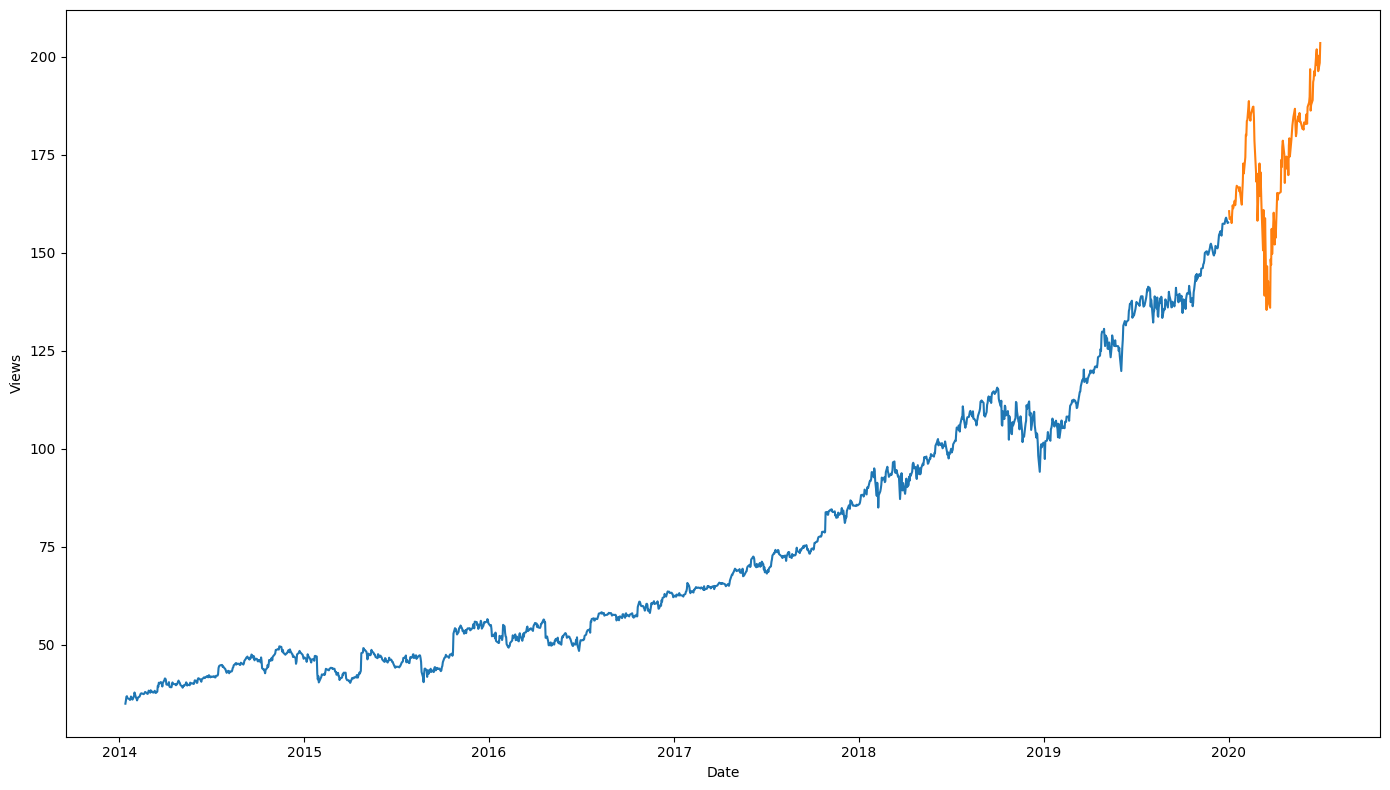

In [69]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_train)
ax.plot(y_test)
ax.set_xlabel('Date')
ax.set_ylabel('Views')

plt.tight_layout()

## 2. Applying ACI Model to make conformal predition.

Once the data is preprocessed and split, we can focus on training a forecasting model. A hyperparameter tuning to have the optimal model using random search is also performed. The best model is saved uisng <b>`best_estimator_attribute`</b>. This search helps us find the optimal hyperparameter for the Random Forest model, which is then used in the ACI model.

In [70]:
#applying the ACI model using partial fit
rf_model = RandomForestRegressor(random_state=59)

# Random Forest Hyperparameters (with regularization)
params = {
    "max_depth": [3, 5],                # Limiting tree depth
    "n_estimators": [50, 100],          # Fewer estimators
    "min_samples_split": [10, 30],      # More samples needed for split
    "min_samples_leaf": [20, 30],       # More samples needed in leaves
    "bootstrap": [True]                 # Keep bootstrap for better generalization
}

# CV parameter search setup
n_iter = 100
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
random_state = 59

# Randomized Search for RandomForestRegressor
rf_model = RandomForestRegressor(random_state=random_state)
cv_obj2 = RandomizedSearchCV(
    rf_model,
    param_distributions=params,
    n_iter=n_iter,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=random_state,
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
cv_obj2.fit(X_train, y_train)

# Best model based on the parameter search
model = cv_obj2.best_estimator_
print("Best Parameters:", cv_obj2.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 5, 'bootstrap': True}


The ACI model is trained with the best Random Forest estimator and is evaluated using partial fitting over a 7-day horizon. The `BlockBootstrap` object provides the cross-validation structure for time-series data. We apply the ACI model with partial fitting on the test data in small chuncks (7 days at a time).

In [71]:
# For a 95% confidence interval, use alpha=0.05
alpha = 0.05

# Set the horizon to 1
h = 7

# Define cv_mapie_ts as a BlockBootstrap object
from mapie.subsample import BlockBootstrap
cv_mapie_ts = BlockBootstrap(
    n_resamplings=10,
    n_blocks=10,
    overlapping=False,
    random_state=59
)

mapie_aci = MapieTimeSeriesRegressor(
    model,
    method='aci',
    cv=cv_mapie_ts,
    agg_function='mean',
    n_jobs=-1
)

mapie_aci = mapie_aci.fit(X_train, y_train)

y_pred_aci, y_pred_int_aci = mapie_aci.predict(
    X_test,
    alpha=alpha,
    ensemble=True)

In [72]:
y_pred_pfit_aci = np.zeros(y_pred_aci.shape)
y_pred_int_pfit_aci = np.zeros(y_pred_int_aci.shape)

y_pred_pfit_aci[:h], y_pred_int_pfit_aci[:h, :, :] = mapie_aci.predict(X_test.iloc[:h, :],
                                                                 alpha=alpha,
                                                                 ensemble=True
                                                                       )

for step in range(h, len(X_test), h):
    mapie_aci.partial_fit(X_test.iloc[(step-h): step, :],
                             y_test.iloc[(step-h):step])

    y_pred_pfit_aci[step:step + h], y_pred_int_pfit_aci[step:step + h, :, :] = mapie_aci.predict(X_test.iloc[step:(step+h), :],
                                                                                           alpha=alpha,
                                                                                           ensemble=True
                                                                                                 )

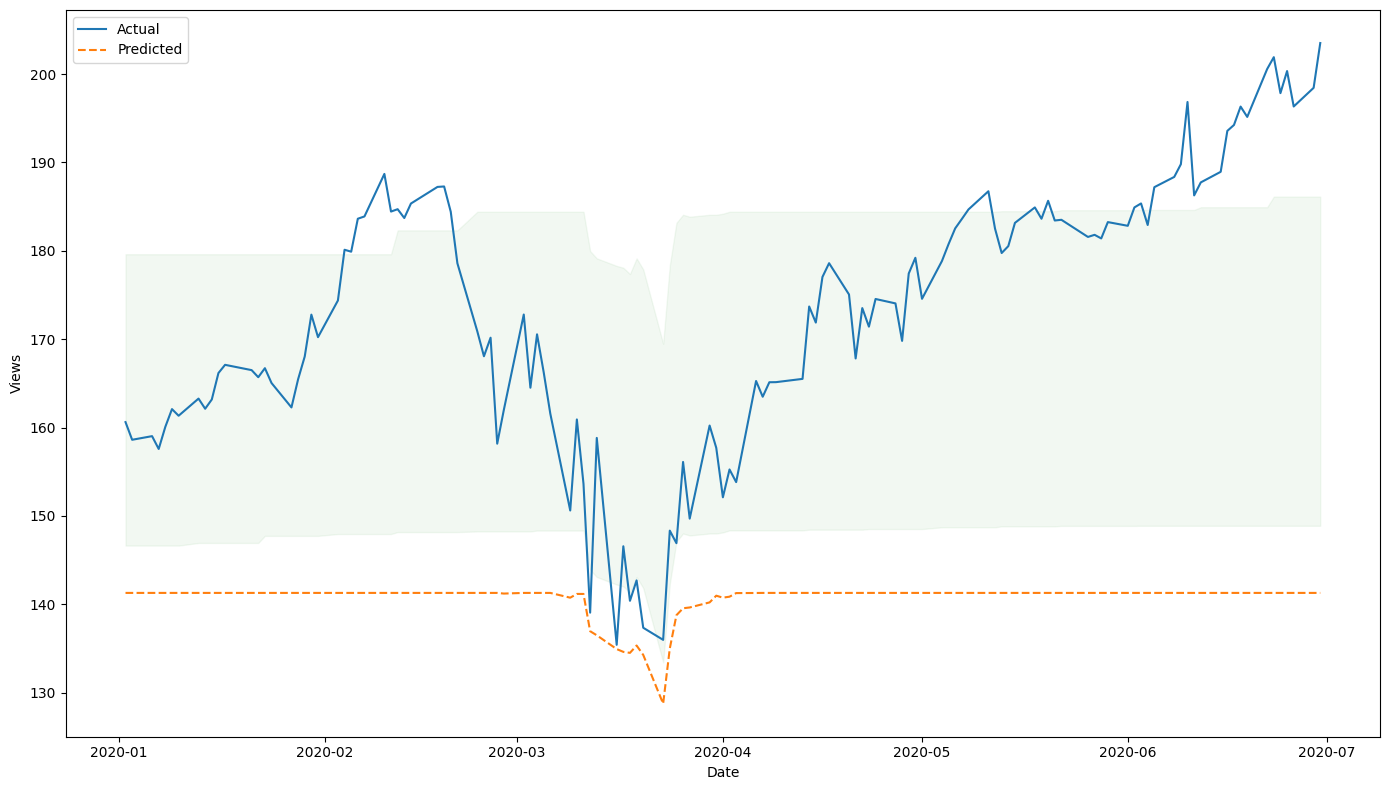

In [73]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_test, label='Actual')
ax.plot(y_test.index, y_pred_pfit_aci, label='Predicted', ls='--')
ax.fill_between(
    y_test.index,
    y_pred_int_pfit_aci[:, 0, 0],
    y_pred_int_pfit_aci[:, 1, 0],
    color='green',
    alpha=alpha
)
ax.set_xlabel('Date')
ax.set_ylabel('Views')
ax.legend(loc='best')

plt.tight_layout()

In [74]:
coverage_pfit = regression_coverage_score(
    y_test, y_pred_int_pfit_aci[:, 0, 0], y_pred_int_pfit_aci[:, 1, 0])

width_interval_pfit = regression_mean_width_score(
    y_pred_int_pfit_aci[:, 0, 0], y_pred_int_pfit_aci[:, 1, 0])

After training, we evaluate the model's performance by calculating the `Coverage` and `Mean Width` of the prediction intervals.

In [75]:
print(coverage_pfit)
print(width_interval_pfit)

0.664
35.076640339562616


## 4. Applying the WCP Model (Weighted Conformal Prediction)

Now, we implement the Weighted Conformal Prediction (WCP) model based on the methodology described in the research paper. This model uses weighted nonconformity scores to account for covariate shifts.


In [76]:
#the weighted conformal prediction model
# Random Forest Hyperparameters (with regularization)
params = {
    "max_depth": [3, 5],                # Limiting tree depth
    "n_estimators": [50, 100],          # Fewer estimators
    "min_samples_split": [10, 30],      # More samples needed for split
    "min_samples_leaf": [20, 30],       # More samples needed in leaves
    "bootstrap": [True]                 # Keep bootstrap for better generalization
}

# CV parameter search setup
n_iter = 100
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
random_state = 59

# Randomized Search for RandomForestRegressor
rf_model = RandomForestRegressor(random_state=random_state)
cv_obj2 = RandomizedSearchCV(
    rf_model,
    param_distributions=params,
    n_iter=n_iter,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=random_state,
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
cv_obj2.fit(X_train, y_train)

# Best model based on the parameter search
best_model = cv_obj2.best_estimator_
print("Best Parameters:", cv_obj2.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 5, 'bootstrap': True}


1. Estimating Likelihood Ratios: The core of the WCP model lies in the ability to handle covariate shift by estimating the likelihood ratio between the training and test covariates. In the paper, the authors leverage a classifier to predict whether a sample comes from the training or test set, using this prediction to compute likelihood ratios. These ratios are then used to weight the nonconformity scores. The paper uses a logistic regression model to estimate likelihood ratios by predicting whether each sample belongs to the training or test set. We replicate this approach, using logistic regression to calculate the likelihood ratios and effectively handle covariate shift between the training and test data.

2. Computing Nonconformity Scores: The paper fits a base model on the training data and calculates residuals (the absolute differences between predicted and actual values), then scales or normalizes these residuals to reflect the degree of nonconformity. We follow the same process, computing and scaling the residuals from the base model, and then weighting them using the likelihood ratios.

3. Generating Prediction Intervals: Both the paper and our approach use the weighted nonconformity scores to compute the quantile that defines the upper and lower bounds of the prediction interval. This ensures that the intervals maintain the desired coverage level while adjusting for covariate shift.

In [77]:
# Function to estimate likelihood ratios (with stricter caps)
def estimate_likelihood_ratios_scaled(X_train, X_test):
    X_combined = np.vstack((X_train, X_test))
    y_combined = np.hstack((np.zeros(len(X_train)), np.ones(len(X_test))))

    clf = LogisticRegression()
    clf.fit(X_combined, y_combined)

    probs_test = clf.predict_proba(X_test)[:, 1]
    likelihood_ratios = probs_test / (1 - probs_test)

    capped_likelihood_ratios = np.clip(likelihood_ratios, 0.3, 45)

    print(f"Capped Likelihood Ratios: {capped_likelihood_ratios}")

    return capped_likelihood_ratios

def nonconformity_scores_scaled(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    residuals = np.abs(y_train - y_pred_train)

    # Apply an additional scaling factor if necessary
    scaled_residuals = residuals / np.std(residuals)

    print(f"Scaled Residuals (nonconformity scores): {scaled_residuals}")

    return scaled_residuals

# Function to calculate normalized nonconformity scores
def nonconformity_scores_normalized(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    residuals = np.abs(y_train - y_pred_train)

    # Normalize residuals
    normalized_residuals = residuals / np.std(residuals)

    print(f"Normalized Residuals (nonconformity scores): {normalized_residuals}")

    return normalized_residuals

# Weighted conformal prediction function with normalized scores
def weighted_conformal_prediction_normalized(model, X_train, y_train, X_test, alpha=0.05):
    likelihood_ratios = estimate_likelihood_ratios_scaled(X_train, X_test)
    nonconformity = nonconformity_scores_normalized(model, X_train, y_train)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    weighted_scores = np.mean(nonconformity) * likelihood_ratios

    if np.all(weighted_scores == 0):
        print("Warning: All weighted scores are zero.")

    quantile = np.quantile(weighted_scores, 1 - alpha)
    print(f"Quantile: {quantile}")
    if quantile == 0:
        print("Warning: Quantile for prediction intervals is zero.")

    lower_bound = y_pred - quantile
    upper_bound = y_pred + quantile

    return lower_bound, upper_bound, y_pred

# Evaluate function to calculate coverage and mean width
def evaluate_intervals_debug(y_true, lower_bound, upper_bound):
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")

    coverage = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    mean_width = np.mean(upper_bound - lower_bound)

    print(f"Coverage: {coverage}")
    print(f"Mean Width: {mean_width}")

    return coverage, mean_width

In [78]:
# Main execution with updated functions
lower_bound, upper_bound, y_pred = weighted_conformal_prediction_normalized(best_model, X_train, y_train, X_test, alpha=0.05)

# Evaluate the intervals with additional debugging
coverage, mean_width = evaluate_intervals_debug(y_test, lower_bound, upper_bound)

Capped Likelihood Ratios: [ 2.54771684  2.07322672  1.73471179  2.71865286 13.34888995  4.25474566
  5.69685238  9.67132659 20.33712006 17.66897925 45.         45.
 45.         45.         45.         45.         45.         45.
 45.         45.         45.         45.         45.         45.
 45.         45.         45.         45.         45.         45.
 45.         45.         45.         45.         45.         45.
 45.         45.         45.         45.         45.         45.
 45.         45.         45.         45.         45.         45.
 45.         45.         45.         45.         45.         45.
 45.         17.92589934 45.         21.43293999  5.54283283  1.68800181
 30.33554011 45.         45.         45.         14.37936918 45.
 45.         45.         45.         45.         45.         45.
 45.         45.         45.         45.         45.         45.
 45.         45.         45.         45.         45.         45.
 45.         45.         45.         45.        

After generating the prediction intervals, we evaluate the performance of the WCP model by calculating its coverage (the proportion of true values that fall within the interval) and mean width (the average size of the interval).

In [79]:
# Print updated results with diagnostics
print(f'Coverage: {coverage:.7f}')
print(f'Mean Width of Interval: {mean_width:.7f}')

Coverage: 0.8320000
Mean Width of Interval: 70.7595201


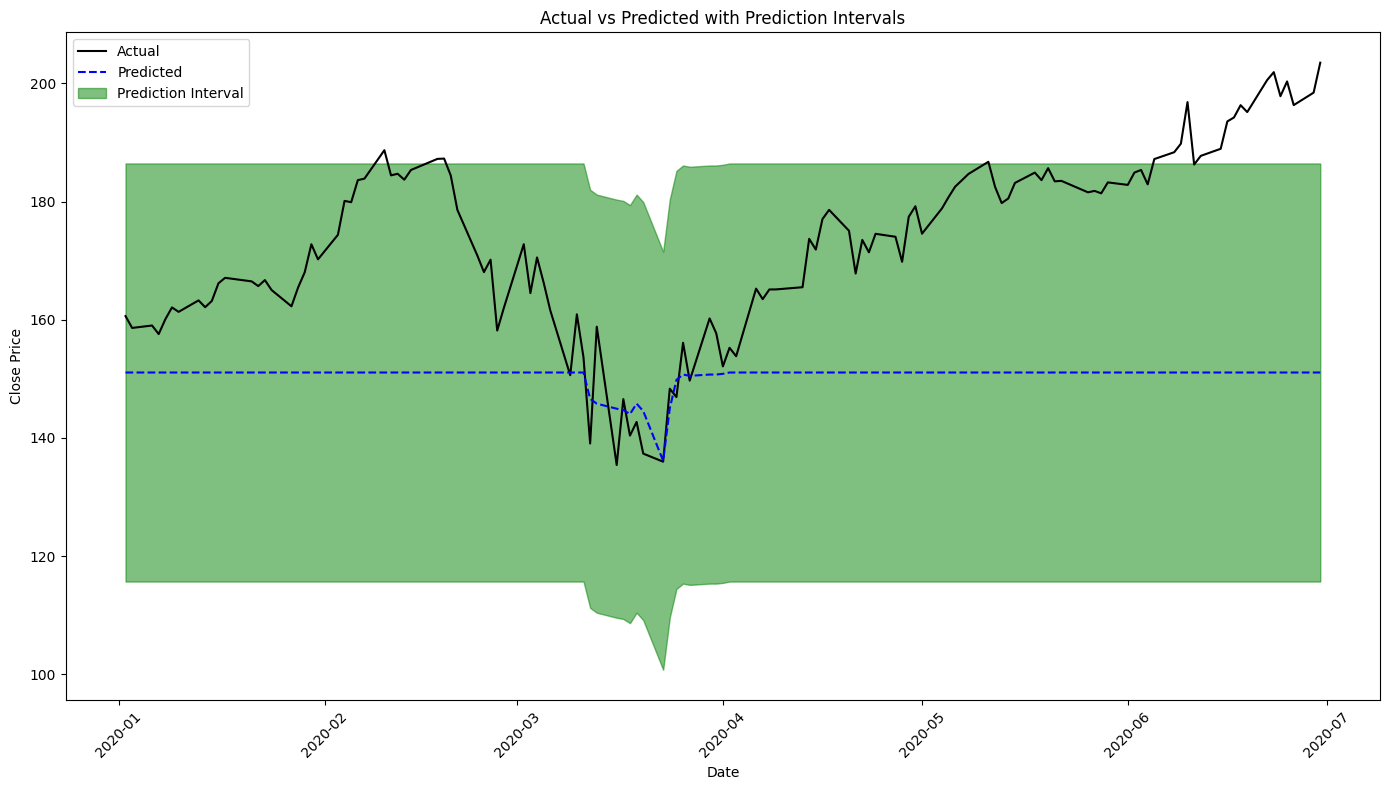

In [80]:
# Plotting function for line graph with dates (improved)
def plot_intervals_time_series_updated(y_test, y_pred, lower_bound, upper_bound, dates):
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot actual vs predicted
    ax.plot(dates, y_test, label='Actual', color='black', linestyle='-')
    ax.plot(dates, y_pred, label='Predicted', linestyle='--', color='blue')

    # Fill between the prediction intervals
    ax.fill_between(
        dates,
        lower_bound,
        upper_bound,
        color='green',
        alpha=0.5,
        label='Prediction Interval'
    )

    # Labels and legend
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.set_title('Actual vs Predicted with Prediction Intervals')
    ax.legend(loc='best')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Ensure all lengths match before plotting
if len(dates_test) == len(y_test) == len(lower_bound) == len(upper_bound) == len(y_pred):
    plot_intervals_time_series_updated(y_test, y_pred, lower_bound, upper_bound, dates_test)
else:
    print("Mismatch in lengths for plotting.")

After implementing both Adaptive Conformal Inference (ACI) and Weighted Conformal Prediction (WCP), the comparative analysis of their performance highlights key differences in how each model handles prediction intervals, especially in the presence of covariate shift.

1. Prediction Interval Coverage:
ACI provided slightly higher coverage in stable conditions, but struggled with significant covariate shifts. WCP, while sometimes offering lower coverage overall, consistently performed better when the test data distribution deviated from the training data. Its ability to handle these shifts made it more reliable in volatile scenarios.

2. Mean Width of Prediction Intervals:
ACI produced narrower intervals, which are useful for precision in stable data. However, WCP’s wider intervals accounted for the uncertainty in shifting data distributions, making it better suited for volatile environments like the stock market.

3. Handling Covariate Shift:
WCP outperformed ACI in managing covariate shift. By adjusting nonconformity scores based on likelihood ratios, WCP adapted well to changes in data distribution, ensuring more consistent performance in unpredictable settings.

Conclusion
ACI is effective for stable datasets, offering precise, narrow intervals. However, for volatile or shifting environments, WCP is the better choice, providing more reliable coverage by explicitly accounting for covariate shift. In dynamic scenarios like stock market forecasting, WCP’s ability to manage uncertainty makes it the preferred model.

In [81]:
# Aggregate the fit performance metrics for m1 and m2
aci_evals = [pd.Series([coverage_pfit]), pd.Series([width_interval_pfit])]
aci_eval_df = pd.concat(aci_evals).reset_index(drop=True)

# Aggregate the partial fit performance metrics for m1 and m2
wcp_evals = [pd.Series([coverage]), pd.Series([mean_width])]
wcp_eval_df = pd.concat(wcp_evals).reset_index(drop=True)

# Concatenate the fit and partial fit evaluation dataframes
eval_df = pd.concat([aci_eval_df, wcp_eval_df], axis=1, keys=["ACI", "WCP"])
eval_df

,ACI,WCP
0,0.66400,0.83200
1,35.07664,70.75952


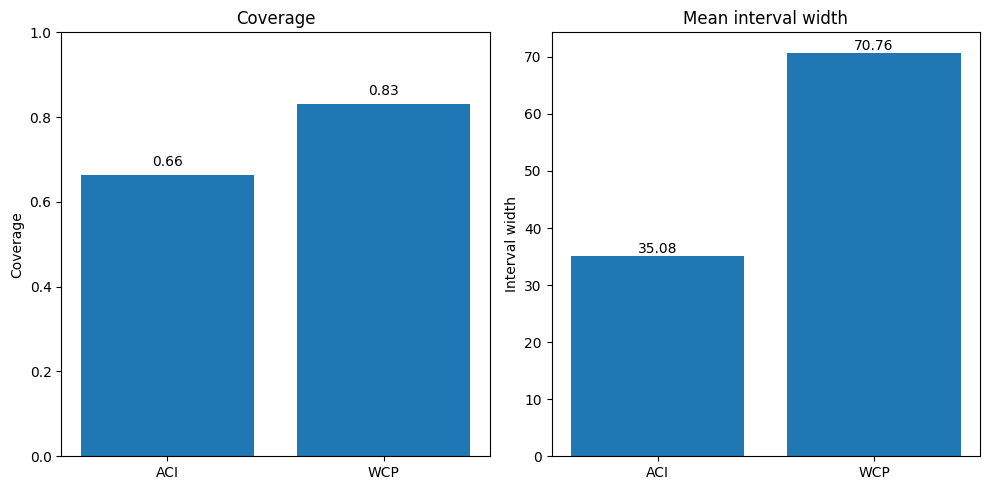

In [93]:
# Extract coverage and mean interval width from the rows
coverage = eval_df.iloc[0]
mean_interval_width = eval_df.iloc[1]
methods = eval_df.columns

# Plotting the coverage
plt.figure(figsize=(10, 5))

# Left plot for coverage
plt.subplot(1, 2, 1)
plt.bar(methods, coverage)
plt.ylabel('Coverage')
plt.ylim(0, 1)
for i, val in enumerate(coverage):
    plt.text(i, val + 0.02, f'{val:.2f}', ha='center')

plt.title('Coverage')

# Right plot for mean interval width
plt.subplot(1, 2, 2)
plt.bar(methods, mean_interval_width)
plt.ylabel('Interval width')
for i, val in enumerate(mean_interval_width):
    plt.text(i, val + 0.5, f'{val:.2f}', ha='center')

plt.title('Mean interval width')

# Show the plot
plt.tight_layout()
plt.show()